# Data Definition:
Independent Variable

- message - the text of the tweet

Dependent Variable

- label - this denotes whether a text is spam or not spam

### Importing Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Finding any NaN values
df.isna().any()

label      False
message    False
dtype: bool

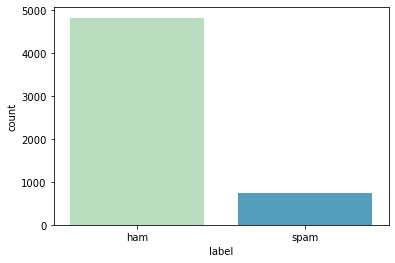

In [4]:
#plot the counts of label
sns.countplot(df['label'], palette='GnBu')
plt.show()

In [5]:
stopword = set(stopwords.words('english'))  #set of stopwords

def total_stopwords(data, target, stopwords):
    list_of_words = []
    
    for word in data[data['label'] == target]['message'].str.split():
        for i in word:
            list_of_words.append(i)
            
    dic = defaultdict(int)
    
    for word_list in list_of_words:
        if word_list in stopword:
            dic[word_list] += 1
            
    top_10 = sorted(dic.items(), key = lambda x : x[1], reverse=True)[:10]
    
    x,y = zip(*top_10)
    
    plt.bar(x, y)
    plt.title("List of stop words")
    plt.show() 

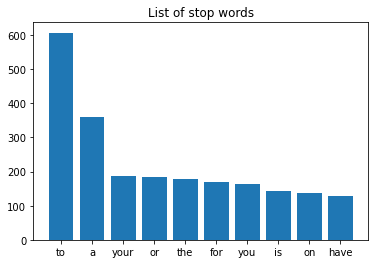

In [6]:
total_stopwords(df, 'spam', stopwords)

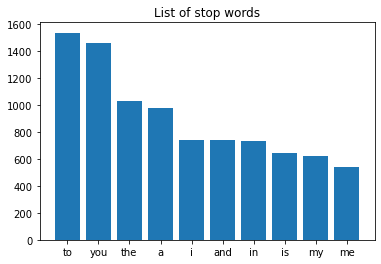

In [7]:
total_stopwords(df, 'ham', stopwords)

In [8]:
# Object of PorterStemmer
wnl = WordNetLemmatizer()
corpus = []
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ',string=df.message[i]) #Removing all ofther data except alphabets
    review = re.sub('\[[^]]*\]', ' ', review)              #Removing Squeare brackets from data
    review = review.lower()
    review = review.split()
    review = [wnl.lemmatize(word) for word in review if((word.isalpha() == 1) & (word not in set(stopwords.words('english'))))]
    review = " ".join(review)
    corpus.append(review)

### Using TfidfVectorizer for Vectorization

In [9]:
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(corpus).toarray()

In [10]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [11]:
#Converting the label to numeric
df['label'] = df['label'].map({'ham' : 0, 'spam' : 1})

In [12]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
y = df['label']

In [14]:
# Creating a pickle file for the TfidfVectorizer
pickle.dump(tfidf, open('tfidf-transform.pkl', 'wb'))

### Spliting data into Train and Test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [16]:
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (4457, 500)
Shape of Validation  (1115, 500)


In [17]:
def plot_scores(name_of_model,X_test,y_test):
    # Predicting the model
    y_pred = name_of_model.predict(X_test)
    
    # Returns confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(10,7))
    p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()
    
    print("\n")
    print("\t\t----------Classification report----------\n")
    # Returns Classification Report
    print(classification_report(y_test, y_pred))

### Building Model

In [18]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

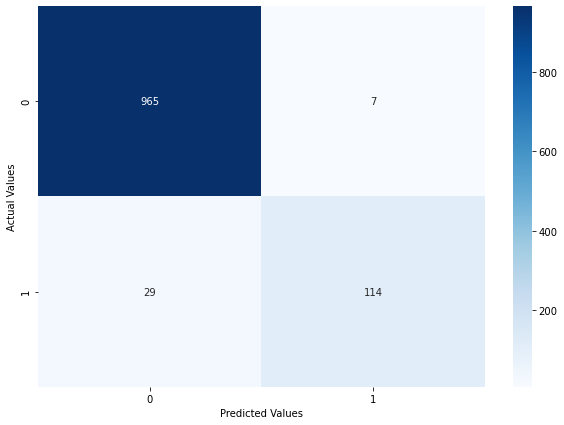



		----------Classification report----------

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       972
           1       0.94      0.80      0.86       143

    accuracy                           0.97      1115
   macro avg       0.96      0.90      0.92      1115
weighted avg       0.97      0.97      0.97      1115



In [19]:
plot_scores(model, X_test, y_test)

In [20]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

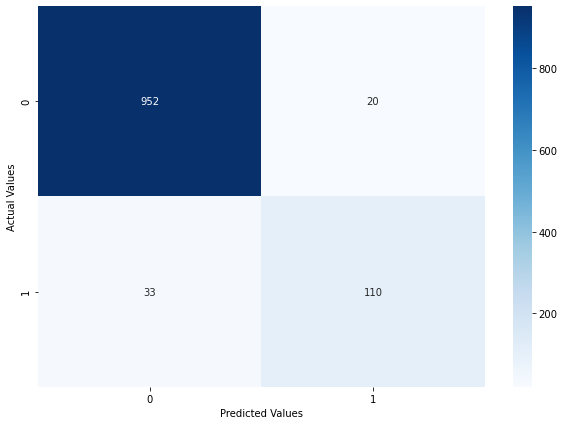



		----------Classification report----------

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       972
           1       0.85      0.77      0.81       143

    accuracy                           0.95      1115
   macro avg       0.91      0.87      0.89      1115
weighted avg       0.95      0.95      0.95      1115



In [21]:
plot_scores(dt, X_test, y_test)

In [22]:
rf = RandomForestClassifier(n_estimators=25)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25)

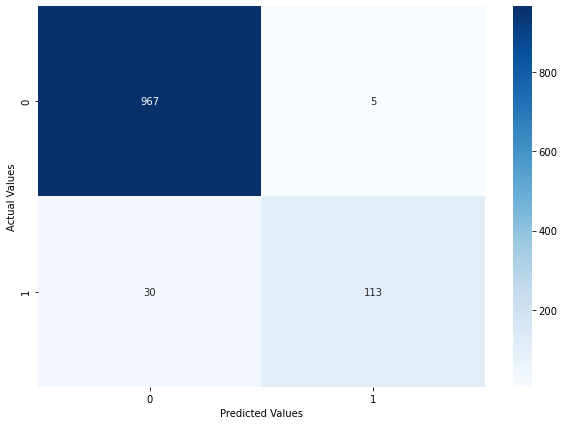



		----------Classification report----------

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       972
           1       0.96      0.79      0.87       143

    accuracy                           0.97      1115
   macro avg       0.96      0.89      0.92      1115
weighted avg       0.97      0.97      0.97      1115



In [23]:
plot_scores(rf, X_test, y_test)

### Making Predictions

In [24]:
def predict_spam(sample_message):
    sample_message = re.sub(pattern='[^a-zA-Z]',repl=' ', string = sample_message)
    sample_message = re.sub('\[[^]]*\]', ' ', sample_message) 
    sample_message = sample_message.lower()
    sample_message_words = sample_message.split()
    sample_message_words = [word for word in sample_message_words if word not in set(stopwords.words('english'))]
    final_message = [wnl.lemmatize(word) for word in sample_message_words]
    final_message = ' '.join(final_message)
    temp = tfidf.transform([final_message]).toarray()
    return rf.predict(temp)

In [25]:
# Prediction 1 - Casual text chat
sample_message = 'Came to think of it. I have never got a spam message before.'

if predict_spam(sample_message):
    print('This is a SPAM message.')
else:
    print('This is a HAM (normal) message.')

This is a HAM (normal) message.


In [26]:
sample_message = 'IMPORTANT - You could be entitled up to £3,160 in compensation from mis-sold PPI on a credit card or loan. Please reply PPI for info or STOP to opt out.'

if predict_spam(sample_message):
    print('Gotcha! This is a SPAM message.')
else:
    print('This is a HAM (normal) message.')

Gotcha! This is a SPAM message.


In [27]:
# Creating a pickle file for the Multinomial Naive Bayes model
filename = 'spam-sms-mnb-model.pkl'
pickle.dump(model, open(filename, 'wb'))